# 初始化库和图像

In [165]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

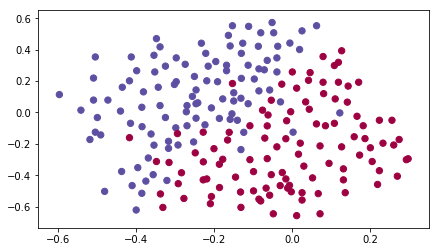

In [166]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [185]:
def model(X, Y, learning_rate = 0.3, num_iterations =30000, print_cost = True, lambd = 0, keep_prob = 1):
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        
        #正向传播,如果存在dropout系统keep_prob<1,则进行正则化正向传播
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        #cost function,如果需要进行L1,L2正则化,在损失函数上做改变
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        #back propagation. 不能同时使用L2和dropout正则化,
        assert(lambd == 0 or keep_prob ==1)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        #update parameters 
        parameters = update_parameters(parameters, grads, learning_rate)
        
        #print the loss every 10000 iterations
        if print_cost and i % 10000 ==0:
            print("cost after iteration{}: {}".format(i, cost))
        if print_cost and i % 1000 ==0:
            costs.append(cost)
        
    #plot the cost 
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations(x1,000)')
    plt.title("learning rate = " + str(learning_rate))
        
    return parameters
    
    
    

# 测试模型不用任何正则化方法

cost after iteration0: 0.6557412523481002
cost after iteration10000: 0.1632998752572417
cost after iteration20000: 0.13851642423284755
on the training set
Accuracy: 0.9478672985781991
on the test set
Accuracy: 0.915


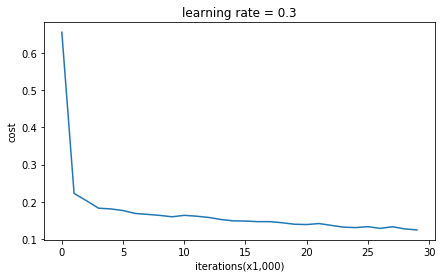

In [168]:
parameters = model(train_X, train_Y)
print("on the training set")
predictions_train =predict(train_X, train_Y, parameters)
print("on the test set")
predictions_train = predict(test_X, test_Y, parameters)

# 绘图观察样例 

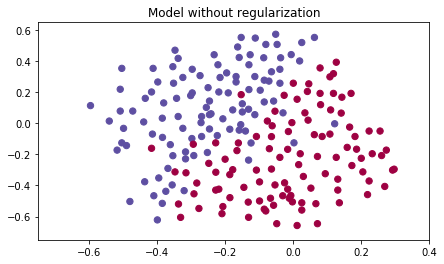

In [169]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.reshape(train_X[0, :].shape), s=40, cmap=plt.cm.Spectral)

In [170]:
X = train_X
y = train_Y
model1 = lambda x: predict_dec(parameters, x.T)

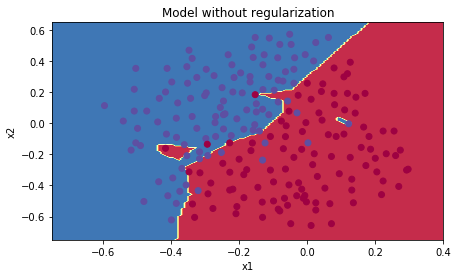

In [171]:
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model1(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title("Model without regularization")
    axes = plt.gca()
    axes.set_xlim([-0.75,0.40])
    axes.set_ylim([-0.75,0.65])
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.reshape(X[0, :].shape), cmap=plt.cm.Spectral)
    plt.show()

将此函数提取出来可以显示
直接用plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)就无法显示图片

# L2正则化的损失函数计算 

In [172]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 =parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"] 
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    L2_regularization_cost = (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))*lambd/(2*m)
    #np.square 平方
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

##  测试样例

In [173]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


# L2正则化的反向传播 

In [174]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m*np.dot(dZ3, A2.T) + lambd/m*W3
    db3 = 1./m*np.sum(dZ3, axis = 1, keepdims =True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    
    dW2 = 1./m*np.dot(dZ2,A1.T) + lambd/m*W2
    db2 = 1./m*np.sum(dZ2,axis = 1, keepdims =True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
    dW1 = 1./m*np.dot(dZ1, X.T) + lambd/m*W1
    db1 = 1./m*np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1,
                "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

In [175]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


cost after iteration0: 0.6974484493131264
cost after iteration10000: 0.2684918873282239
cost after iteration20000: 0.2680916337127301
On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


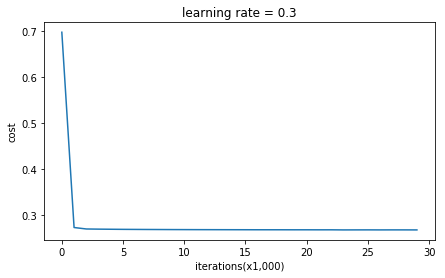

In [176]:


parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)



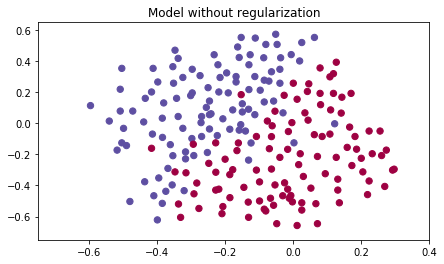

In [177]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.reshape(train_X[0, :].shape), s=40, cmap=plt.cm.Spectral)

In [178]:
X = train_X
y = train_Y
model2 = lambda x: predict_dec(parameters, x.T)

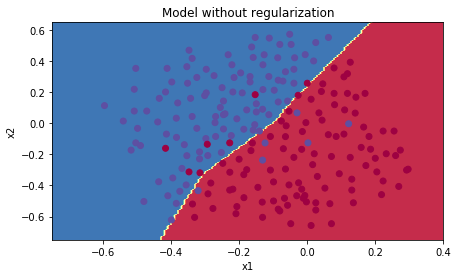

In [179]:
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole grid
Z = model2(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(X[0, :], X[1, :], c=y.reshape(X[0, :].shape), cmap=plt.cm.Spectral)
plt.show()

# dropout随机失活正则化

## dropout正向传播 

In [180]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    D1 = D1<keep_prob
    
    A1 = np.multiply(A1, D1)
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = D2 < keep_prob
    
    A2 = np.multiply(A2, D2)
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [181]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))


A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


## dropout反向传播 

In [182]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m*np.dot(dZ3, A2.T)
    db3 = 1./m*np.sum(dZ3, axis=1, keepdims= True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = np.multiply(D2, dA2)
    dA2 = dA2/ keep_prob
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m *np.dot(dZ2, A1.T)
    db2 = 1./m *np.sum(dZ2, axis = 1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1, D1)
    dA1 = dA1 / keep_prob
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m *np.dot(dZ1, X.T)
    db1 = 1./m *np.sum(dZ1, axis = 1, keepdims= True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [183]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


cost after iteration0: 0.6543912405149825


/home/tree/git_file/深度学习/第二门课第一周/assign1/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  
/home/tree/git_file/深度学习/第二门课第一周/assign1/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  


cost after iteration10000: 0.0610169865749056
cost after iteration20000: 0.060582435798513114
On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


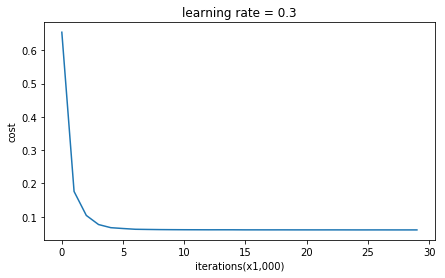

In [186]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)